# ライブラリ

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# warningsを表示しない
import warnings

warnings.filterwarnings("ignore")

# 5.2 回帰不連続デザイン（RDD）

## 5.2.3 メールによる来訪率の増加効果を分析する

In [2]:
# データ読み込み
email_data = pd.read_csv(
    "http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv"
)
email_data.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


In [3]:
# ルールによるメールの配信を行ったログを作成
male_data = email_data.copy()
male_data = male_data[
    (male_data["segment"] == "No E-Mail") | (male_data["segment"] == "Mens E-Mail")
]  # segment == Womens E-Mailを落とす
male_data["treatment"] = male_data["segment"].apply(
    lambda x: 1 if x == "Mens E-Mail" else 0
)  # 変数treatment作成
male_data["history_log"] = np.log(male_data["history"])  # 変数history_log作成
male_data.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment,history_log
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0,0,5.796301
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0,1,6.515942
8,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0,1,6.514816
13,2,2) $100 - $200,101.64,0,1,Urban,0,Web,Mens E-Mail,1,0,0.0,1,4.621437
14,4,3) $200 - $350,241.42,0,1,Rural,1,Multichannel,No E-Mail,0,0,0.0,0,5.486538


In [4]:
# 図5.2作成用データ
male_data["history_log_grp"] = np.round(male_data["history_log"] / 0.1) * 0.1
meanvisit = (
    male_data.groupby(["segment", "history_log_grp"])
    .agg(visit=("visit", "mean"), N=("visit", "count"))
    .reset_index()
)
meanvisit = meanvisit[meanvisit["N"] > 10]
meanvisit.head()

,segment,history_log_grp,visit,N
0,Mens E-Mail,3.4,0.146545,2750
1,Mens E-Mail,3.5,0.169118,272
2,Mens E-Mail,3.6,0.158576,309
3,Mens E-Mail,3.7,0.131343,335
4,Mens E-Mail,3.8,0.184615,390


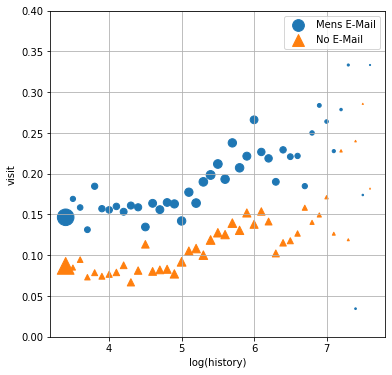

In [ ]:
# 図5.2：実験データにおける来訪率とlog(history_i)
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(
    meanvisit[meanvisit["segment"] == "Mens E-Mail"]["history_log_grp"],
    meanvisit[meanvisit["segment"] == "Mens E-Mail"]["visit"],
    marker="o",
    label="Mens E-Mail",
    s=meanvisit[meanvisit["segment"] == "Mens E-Mail"]["N"] / 10,
)
ax.scatter(
    meanvisit[meanvisit["segment"] == "No E-Mail"]["history_log_grp"],
    meanvisit[meanvisit["segment"] == "No E-Mail"]["visit"],
    marker="^",
    label="No E-Mail",
    s=meanvisit[meanvisit["segment"] == "No E-Mail"]["N"] / 10,
)
ax.set_xlabel("log(history)")
ax.set_ylabel("visit")
ax.set_ylim(0, 0.4)
ax.legend(loc="best")
ax.grid(True)

In [5]:
# カットオフ近辺での介入グループと非介入グループの差
meanvisit[
    (5.0 <= meanvisit["history_log_grp"]) & (meanvisit["history_log_grp"] <= 6.0)
].groupby("segment")["visit"].mean()

segment
Mens E-Mail    0.200884
No E-Mail      0.121530
Name: visit, dtype: float64

In [6]:
# cut-offの値を指定
threshold_value = 5.5

# ルールによる介入を再現したデータの作成
rdd_data = male_data[
    (
        (
            (male_data["history_log"] > threshold_value)
            & (male_data["segment"] == "Mens E-Mail")
        )
        | (
            (male_data["history_log"] <= threshold_value)
            & (male_data["segment"] == "No E-Mail")
        )
    )
]
rdd_data.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment,history_log,history_log_grp
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0,1,6.515942,6.5
8,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0,1,6.514816,6.5
14,4,3) $200 - $350,241.42,0,1,Rural,1,Multichannel,No E-Mail,0,0,0.0,0,5.486538,5.5
15,3,1) $0 - $100,58.13,1,0,Urban,1,Web,No E-Mail,1,0,0.0,0,4.062682,4.1
19,5,"6) $750 - $1,000",828.42,1,0,Surburban,1,Multichannel,Mens E-Mail,0,0,0.0,1,6.719520,6.7


In [7]:
# 図5.3作成用データ
meanvisit = (
    rdd_data.groupby(["segment", "history_log_grp"])
    .agg(visit=("visit", "mean"), N=("visit", "count"))
    .reset_index()
)
meanvisit = meanvisit[meanvisit["N"] > 10]
meanvisit.head()

,segment,history_log_grp,visit,N
0,Mens E-Mail,5.5,0.235450,378
1,Mens E-Mail,5.6,0.193277,714
2,Mens E-Mail,5.7,0.237822,698
3,Mens E-Mail,5.8,0.207232,719
4,Mens E-Mail,5.9,0.221519,632


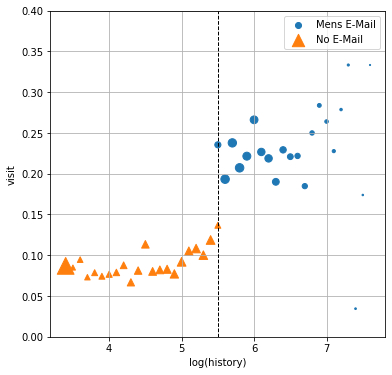

In [ ]:
# 図5.3：非実験データにおける来訪率とlog(history_i)
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(
    meanvisit[meanvisit["segment"] == "Mens E-Mail"]["history_log_grp"],
    meanvisit[meanvisit["segment"] == "Mens E-Mail"]["visit"],
    marker="o",
    label="Mens E-Mail",
    s=meanvisit[meanvisit["segment"] == "Mens E-Mail"]["N"] / 10,
)
ax.scatter(
    meanvisit[meanvisit["segment"] == "No E-Mail"]["history_log_grp"],
    meanvisit[meanvisit["segment"] == "No E-Mail"]["visit"],
    marker="^",
    label="No E-Mail",
    s=meanvisit[meanvisit["segment"] == "No E-Mail"]["N"] / 10,
)
ax.vlines(x=5.5, ymin=0, ymax=0.4, linestyle="--", linewidth=1)
ax.set_xlabel("log(history)")
ax.set_ylabel("visit")
ax.set_ylim(0, 0.4)
ax.legend(loc="best")
ax.grid(True)

### 集計による分析

In [8]:
# RDDデータでの比較
rdd_data_table = (
    rdd_data.groupby("treatment")
    .agg(count=("visit", "count"), visit_rate=("visit", "mean"))
    .reset_index()
)
print(rdd_data_table)
mean_diff = rdd_data_table["visit_rate"][1] - rdd_data_table["visit_rate"][0]
print(f"\n平均値の差：{mean_diff:.3g}")

   treatment  count  visit_rate
0          0  13926    0.090694
1          1   7366    0.224002

平均値の差：0.133


### 線形回帰による分析

In [9]:
Y = rdd_data["visit"]
X = sm.add_constant(rdd_data[["treatment", "history_log"]])

# Y = β0 + β1*treatment + β2*history_log + ε
rdd_lm_reg = sm.OLS(Y, X).fit()
coef = rdd_lm_reg.summary().tables[1]
coef = pd.read_html(coef.as_html(), header=0, index_col=0)[0]
pd.DataFrame(coef.loc["treatment"]).T

,coef,std err,t,P>|t|,[0.025,0.975]
treatment,0.1137,0.008,14.24,0.0,0.098,0.129


### 線形回帰による分析：結果の可視化

In [10]:
# 図作成用データ
rdd_data["lm_pred"] = rdd_lm_reg.predict(X)
meanvisit = (
    rdd_data.groupby(["segment", "history_log_grp"])
    .agg(N=("visit", "count"), visit=("visit", "mean"), lm_pred=("lm_pred", "mean"))
    .reset_index()
)
meanvisit = meanvisit[meanvisit["N"] > 10]
meanvisit.head()

,segment,history_log_grp,N,visit,lm_pred
0,Mens E-Mail,5.5,378,0.235450,0.217221
1,Mens E-Mail,5.6,714,0.193277,0.218036
2,Mens E-Mail,5.7,698,0.237822,0.219198
3,Mens E-Mail,5.8,719,0.207232,0.220346
4,Mens E-Mail,5.9,632,0.221519,0.221474


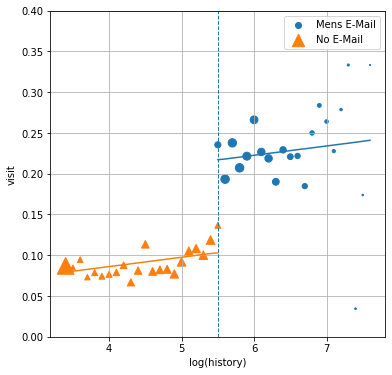

In [11]:
# 描画
fig, ax = plt.subplots(figsize=(6, 6))

# 散布図
ax.scatter(
    meanvisit[meanvisit["segment"] == "Mens E-Mail"]["history_log_grp"],
    meanvisit[meanvisit["segment"] == "Mens E-Mail"]["visit"],
    marker="o",
    label="Mens E-Mail",
    s=meanvisit[meanvisit["segment"] == "Mens E-Mail"]["N"] / 10,
)
ax.scatter(
    meanvisit[meanvisit["segment"] == "No E-Mail"]["history_log_grp"],
    meanvisit[meanvisit["segment"] == "No E-Mail"]["visit"],
    marker="^",
    label="No E-Mail",
    s=meanvisit[meanvisit["segment"] == "No E-Mail"]["N"] / 10,
)

# 回帰直線
ax.plot(
    meanvisit[meanvisit["segment"] == "Mens E-Mail"]["history_log_grp"],
    meanvisit[meanvisit["segment"] == "Mens E-Mail"]["lm_pred"],
)  # カットオフ値以上
ax.plot(
    meanvisit[meanvisit["segment"] == "No E-Mail"]["history_log_grp"],
    meanvisit[meanvisit["segment"] == "No E-Mail"]["lm_pred"],
)  # カットオフ値未満

# その他
ax.vlines(x=5.5, ymin=0, ymax=0.4, linestyle="--", linewidth=1)
ax.set_xlabel("log(history)")
ax.set_ylabel("visit")
ax.set_ylim(0, 0.4)
ax.legend(loc="best")
ax.grid(True)

### 線形回帰による分析：カットオフ値前後でデータを分けて各々線形回帰

In [13]:
# データを分割
rdd_data_l = rdd_data[
    rdd_data["history_log"] < threshold_value
].copy()  # カットオフ値未満
rdd_data_r = rdd_data[
    rdd_data["history_log"] >= threshold_value
].copy()  # カットオフ値以上

# 分割したデータごとに回帰

# カットオフ値未満
Y_l = rdd_data_l["visit"]
X_l = sm.add_constant(rdd_data_l["history_log"])
reg_l = sm.OLS(Y_l, X_l).fit()

# カットオフ値以上
Y_r = rdd_data_r["visit"]
X_r = sm.add_constant(rdd_data_r["history_log"])
reg_r = sm.OLS(Y_r, X_r).fit()

# カットオフ値における予測値の差
print(
    (reg_r.params[0] + reg_r.params[1] * 5.5)
    - (reg_l.params[0] + reg_l.params[1] * 5.5)
)

0.11359235208736695


### 非線形回帰による分析：カットオフ値前後で分けて各々非線形回帰

In [19]:
# 変数作成
rdd_data["history_log2"] = rdd_data["history_log"] ** 2
rdd_data["history_log3"] = rdd_data["history_log"] ** 3
rdd_data["history_log4"] = rdd_data["history_log"] ** 4

# データを分割
rdd_data_l = rdd_data[
    rdd_data["history_log"] < threshold_value
].copy()  # カットオフ値未満
rdd_data_r = rdd_data[
    rdd_data["history_log"] >= threshold_value
].copy()  # カットオフ値以上

# 分割したデータごとに回帰（history_logを4乗項まで追加）

# カットオフ値未満
Y_l = rdd_data_l["visit"]
X_l = sm.add_constant(
    rdd_data_l[["history_log", "history_log2", "history_log3", "history_log4"]]
)
reg_l = sm.OLS(Y_l, X_l).fit()
rdd_data_l["pred"] = reg_l.predict(X_l)

# カットオフ値以上
Y_r = rdd_data_r["visit"]
X_r = sm.add_constant(
    rdd_data_r[["history_log", "history_log2", "history_log3", "history_log4"]]
)
reg_r = sm.OLS(Y_r, X_r).fit()
rdd_data_r["pred"] = reg_r.predict(X_r)

# カットオフ値における予測値の差
cutoff = 5.5
print(
    (
        # カットオフ値未満
        reg_r.params[0]
        + reg_r.params[1] * cutoff
        + reg_r.params[2] * (cutoff**2)
        + reg_r.params[3] * (cutoff**3)
        + reg_r.params[4] * (cutoff**4)
    )
    - (
        # カットオフ値以上
        reg_l.params[0]
        + reg_l.params[1] * cutoff
        + reg_l.params[2] * (cutoff**2)
        + reg_l.params[3] * (cutoff**3)
        + reg_l.params[4] * (cutoff**4)
    )
)

0.07407940918254496


### 非線形回帰による分析：結果の可視化

In [20]:
# 図作成用データ
rdd_data_lr = pd.concat([rdd_data_l, rdd_data_r], axis=0)
meanvisit = (
    rdd_data_lr.groupby(["segment", "history_log_grp"])
    .agg(N=("visit", "count"), visit=("visit", "mean"), pred=("pred", "mean"))
    .reset_index()
)
meanvisit = meanvisit[meanvisit["N"] > 10]
meanvisit.head()

,segment,history_log_grp,N,visit,pred
0,Mens E-Mail,5.5,378,0.235450,0.209574
1,Mens E-Mail,5.6,714,0.193277,0.215743
2,Mens E-Mail,5.7,698,0.237822,0.221816
3,Mens E-Mail,5.8,719,0.207232,0.225157
4,Mens E-Mail,5.9,632,0.221519,0.226491


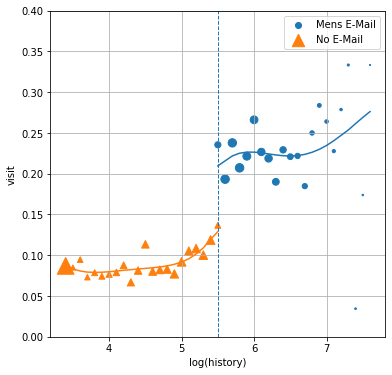

In [17]:
# 描画
fig, ax = plt.subplots(figsize=(6, 6))

# 散布図
ax.scatter(
    meanvisit[meanvisit["segment"] == "Mens E-Mail"]["history_log_grp"],
    meanvisit[meanvisit["segment"] == "Mens E-Mail"]["visit"],
    marker="o",
    label="Mens E-Mail",
    s=meanvisit[meanvisit["segment"] == "Mens E-Mail"]["N"] / 10,
)
ax.scatter(
    meanvisit[meanvisit["segment"] == "No E-Mail"]["history_log_grp"],
    meanvisit[meanvisit["segment"] == "No E-Mail"]["visit"],
    marker="^",
    label="No E-Mail",
    s=meanvisit[meanvisit["segment"] == "No E-Mail"]["N"] / 10,
)

# 回帰直線
ax.plot(
    meanvisit[meanvisit["segment"] == "Mens E-Mail"]["history_log_grp"],
    meanvisit[meanvisit["segment"] == "Mens E-Mail"]["pred"],
)  # カットオフ値以上
ax.plot(
    meanvisit[meanvisit["segment"] == "No E-Mail"]["history_log_grp"],
    meanvisit[meanvisit["segment"] == "No E-Mail"]["pred"],
)  # カットオフ値未満

# その他
ax.vlines(x=5.5, ymin=0, ymax=0.4, linestyle="--", linewidth=1)
ax.set_xlabel("log(history)")
ax.set_ylabel("visit")
ax.set_ylim(0, 0.4)
ax.legend(loc="best")
ax.grid(True)

# 5.3 nonparametric RDD
- 参考：『因果推論　基礎から機械学習・時系列解析・因果探索を用いた意思決定のアプローチ』



In [48]:
# libraries
#!pip install rdrobust==1.2.0
#!pip install rddensity==2.4.1
import rdrobust
import rddensity

## 使用データ再掲

In [24]:
rdd_data.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment,history_log,history_log_grp,lm_pred,history_log2,history_log3,history_log4
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0,1,6.515942,6.5,0.228529,42.457494,276.650553,1802.638838
8,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0,1,6.514816,6.5,0.228516,42.442833,276.507261,1801.394038
14,4,3) $200 - $350,241.42,0,1,Rural,1,Multichannel,No E-Mail,0,0,0.0,0,5.486538,5.5,0.103094,30.102101,165.156325,906.136480
15,3,1) $0 - $100,58.13,1,0,Urban,1,Web,No E-Mail,1,0,0.0,0,4.062682,4.1,0.086822,16.505384,67.056125,272.427703
19,5,"6) $750 - $1,000",828.42,1,0,Surburban,1,Multichannel,Mens E-Mail,0,0,0.0,1,6.719520,6.7,0.230856,45.151953,303.399461,2038.698832


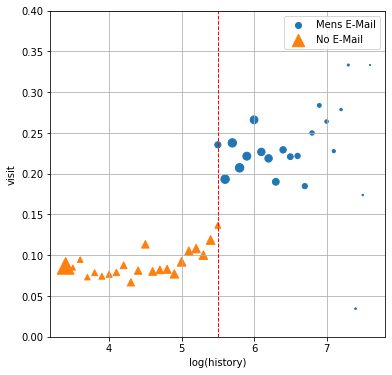

In [46]:
# 可視化
# ※history_logを0.1刻みで平均したもの
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(
    meanvisit[meanvisit["segment"] == "Mens E-Mail"]["history_log_grp"],
    meanvisit[meanvisit["segment"] == "Mens E-Mail"]["visit"],
    marker="o",
    label="Mens E-Mail",
    s=meanvisit[meanvisit["segment"] == "Mens E-Mail"]["N"] / 10,
)
ax.scatter(
    meanvisit[meanvisit["segment"] == "No E-Mail"]["history_log_grp"],
    meanvisit[meanvisit["segment"] == "No E-Mail"]["visit"],
    marker="^",
    label="No E-Mail",
    s=meanvisit[meanvisit["segment"] == "No E-Mail"]["N"] / 10,
)
ax.vlines(x=5.5, color="r", ymin=0, ymax=0.4, linestyle="--", linewidth=1)
ax.set_xlabel("log(history)")
ax.set_ylabel("visit")
ax.set_ylim(0, 0.4)
ax.legend(loc="best")
ax.grid(True)

In [ ]:
# カットオフ値
cutoff = 5.5

In [49]:
# 処置効果の推定
Y = rdd_data["visit"]
X = rdd_data["history_log"]
rdrobust.rdrobust(Y, X, c=cutoff)

Mass points detected in the running variable.
Mass points detected in the running variable.
Call: rdrobust
Number of Observations:                 21292
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations         13926       7366
Number of Unique Obs.           8632       6886
Number of Effective Obs.        3851       3602
Bandwidth Estimation           0.525      0.525
Bandwidth Bias                 0.819      0.819
rho (h/b)                      0.641      0.641

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.084    0.019    4.481   7.423e-06      [0.047, 0.12]
Robust     

Mass points detected in the running variable.


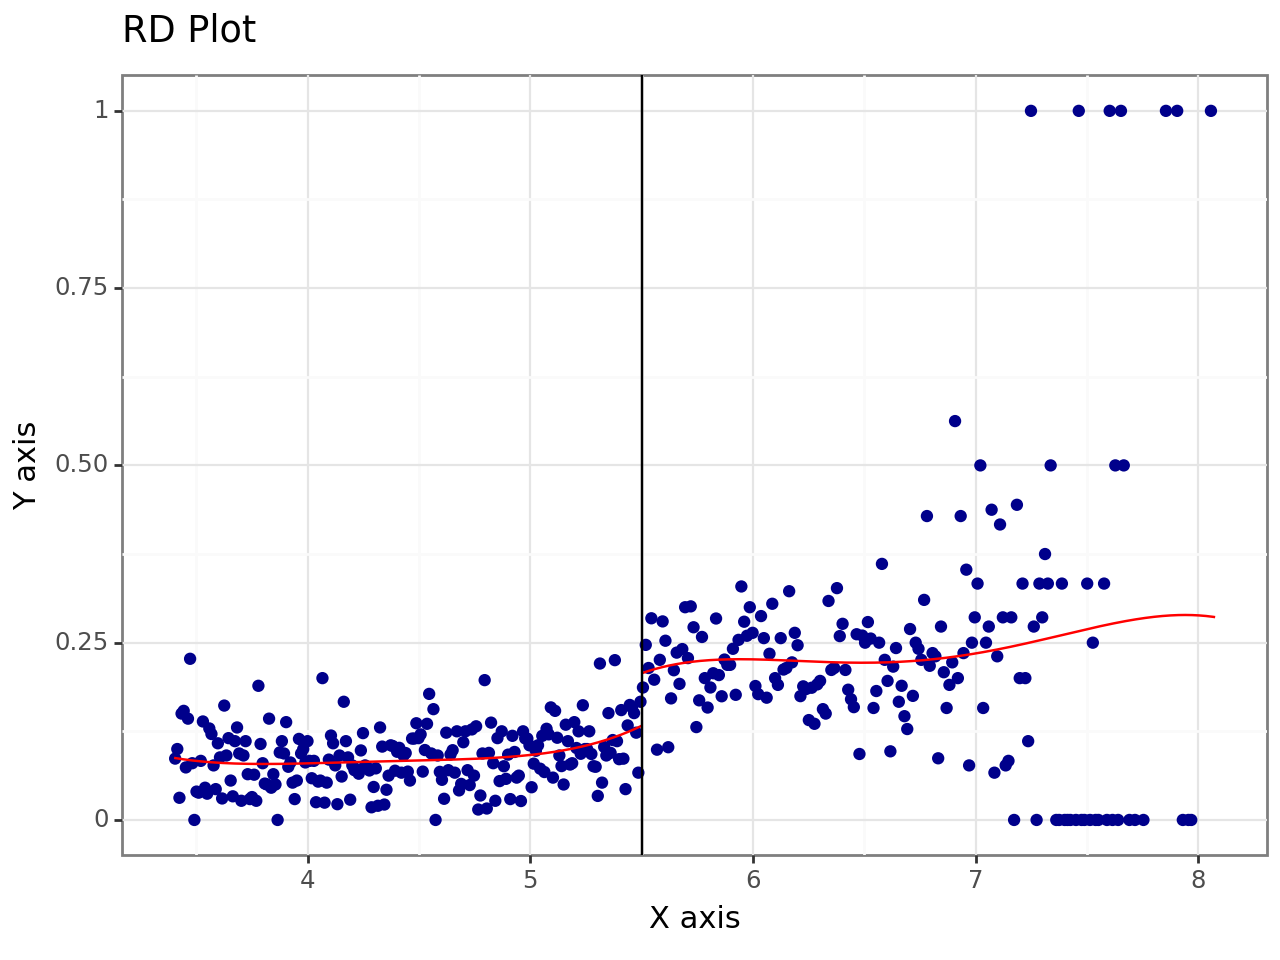


Call: rdplot
Number of Observations:                 21292
Kernel:                               Uniform
Polynomial Order Est. (p):                  4

                                Left      Right
------------------------------------------------
Number of Observations         13926       7366
Number of Effective Obs        13926       7366
Bandwith poly. fit (h)         2.099      2.576
Number of bins scale               1          1
Bins Selected                    219        204
Average Bin Length              0.01      0.013
Median Bin Length               0.01      0.013
IMSE-optimal bins                8.0        5.0
Mimicking Variance bins        219.0      204.0

Relative to IMSE-optimal:
Implied scale                 27.375       40.8
WIMSE variance weight            0.0        0.0
WIMSE bias weight                1.0        1.0


In [51]:
# RDプロット
rdrobust.rdplot(Y, X, c=cutoff)

In [55]:
# プラセボテスト
# ※設定したカットオフ値以外でジャンプがないかどうか
rdrobust.rdrobust(Y, X, c=6.0)

Mass points detected in the running variable.
Mass points detected in the running variable.
Call: rdrobust
Number of Observations:                 21292
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations         17375       3917
Number of Unique Obs.          11744       3774
Number of Effective Obs.        3434       2437
Bandwidth Estimation           0.498      0.498
Bandwidth Bias                 0.783      0.783
rho (h/b)                      0.636      0.636

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       -0.03    0.025    -1.21   2.262e-01    [-0.078, 0.018]
Robust     

## 仮定の確認

### 強制変数の連続性（non-manipulation）

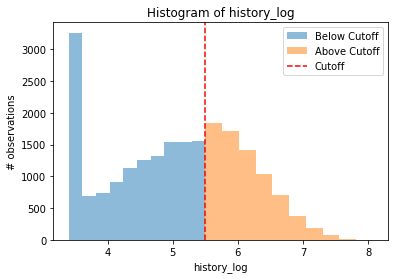

In [35]:
# history_logのヒストグラム
plt.hist(
    rdd_data[rdd_data["history_log"] < cutoff]["history_log"],
    bins=10,
    alpha=0.5,
    label="Below Cutoff",
)
plt.hist(
    rdd_data[rdd_data["history_log"] >= cutoff]["history_log"],
    bins=10,
    alpha=0.5,
    label="Above Cutoff",
)
plt.axvline(x=cutoff, color="r", linestyle="--", label="Cutoff")
plt.xlabel("history_log")
plt.ylabel("# observations")
plt.title("Histogram of history_log")
plt.legend()

In [50]:
# 連続性の検定
# H0: カットオフ値において連続
# H1: カットオフ値において連続でない
# ⇒ H0を棄却できない ⇔ 「連続でないとはいえない」
rddensity.rddensity(X, c=cutoff)

Manipulation testing using local polynomial density estimation
Number of obs:                             21292
Model:                              unrestricted
Kernel:                               triangular
BW method:                             estimated
VCE:                                   jackknife

c = 5.5                             Left of c             Right of c
Number of obs:                          13926                   7366
Eff. number of obs:                      3744                   3037
Order est. (p):                             2                      2
Order bias. (q):                            3                      3
BW est.                                0.5108                 0.4318

Method:                                     T                P > |T|
Robust                                 1.1647                 0.2441

P-values of binomial tests (H0: p =  [0.5] ).

Window Length/2                           < c                     >= c                    